In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
%matplotlib inline

# Load dataset

In [137]:
dataset = pd.read_csv('dataset/dev1_works_distance_dataset.csv')
y = dataset['label'].values
features = dataset.columns.difference(['label'])
#features = ['title', 'primary_author', 'publisher.publisher_name']
print(features)
X = dataset[features].values
dataset.head()

Index(['contributor.name', 'contributor.role', 'country_of_publication',
       'idno', 'idno.type', 'language', 'primary_author', 'publication_type',
       'publisher.place_of_publication', 'publisher.publisher_name',
       'publishing_work_items.type', 'publishing_work_items.unit',
       'publishing_work_items.value', 'subject', 'title'],
      dtype='object')


,publisher.publisher_name,publisher.place_of_publication,publication_type,country_of_publication,language,contributor.name,contributor.role,title,idno,idno.type,subject,publishing_work_items.value,publishing_work_items.type,publishing_work_items.unit,primary_author,label
0,100,100,0,100,0,0,0,100,67,0,0,0,0,0,0,0
1,100,100,0,100,0,0,0,100,67,0,0,0,0,0,0,0
2,37,35,100,100,0,0,0,100,40,0,0,0,100,100,0,0
3,33,31,100,0,0,33,100,100,30,0,0,0,100,100,16,0
4,100,42,100,0,0,0,0,100,61,0,0,0,0,0,0,0


## Split dataset by label (match|not_match) for visualisation

In [138]:
dataset_matched = dataset[dataset['label']==1]
dataset_not_matched = dataset[dataset['label']==0]

In [139]:
print(sum(dataset_matched[features].mean()))
print(sum(dataset_not_matched[features].mean()))

589.078072305
550.099324124


In [140]:
def broken_plot(dataset, column, axis0_limits, axis1_limits, num_bins):
    f, axis = plt.subplots(2, 1, sharex=True)
    axis[0].hist(dataset[[column]].values, num_bins, alpha=0.5)
    axis[1].hist(dataset[[column]].values, num_bins, alpha=0.5)
    axis[0].set_ylim(axis0_limits[0], axis0_limits[1])
    axis[1].set_ylim(axis1_limits[0], axis1_limits[1])

    axis[0].spines['bottom'].set_visible(False)
    axis[1].spines['top'].set_visible(False)
    axis[0].xaxis.tick_top()
    axis[0].tick_params(labeltop='off')
    axis[1].xaxis.tick_bottom()
    d = .015
    kwargs = dict(transform=axis[0].transAxes, color='k', clip_on=False)
    axis[0].plot((-d,+d),(-d,+d), **kwargs)
    axis[0].plot((1-d,1+d),(-d,+d), **kwargs)
    kwargs.update(transform=axis[1].transAxes)
    axis[1].plot((-d,+d),(1-d,1+d), **kwargs)
    axis[1].plot((1-d,1+d),(1-d,1+d), **kwargs)

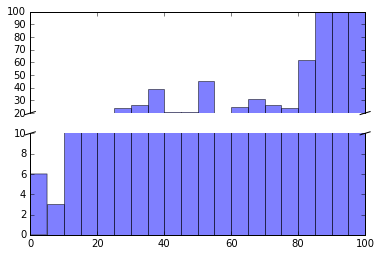

In [141]:
broken_plot(dataset, 'title', (20, 100), (0, 10), 20)

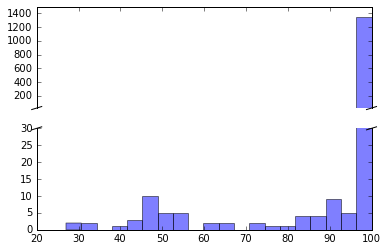

In [142]:
broken_plot(dataset_matched, 'title', (20, 1500), (0, 30), 20)

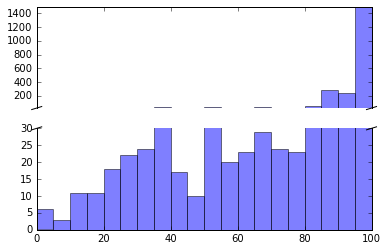

In [143]:
broken_plot(dataset_not_matched, 'title', (20, 1500), (0, 30), 20)

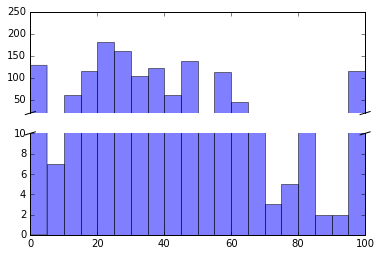

In [144]:
broken_plot(dataset_matched, 'idno', (20, 250), (0, 10), 20)

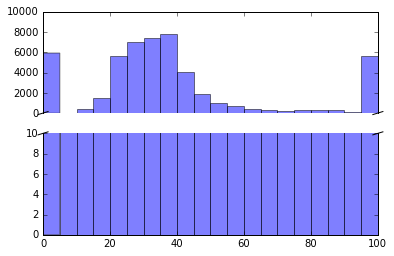

In [145]:
broken_plot(dataset_not_matched, 'idno', (20, 10000), (0, 10), 20)

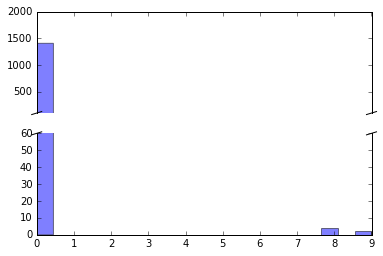

In [146]:
broken_plot(dataset_matched, 'subject', (100, 2000), (0, 60), 20)

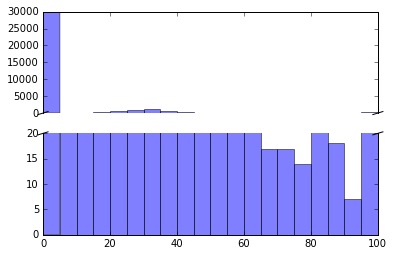

In [147]:
broken_plot(dataset_not_matched, 'subject', (20, 30000), (0, 20), 20)

# Applying classification

## Splitting dataset to train and test

In [148]:
from sklearn.cross_validation import StratifiedShuffleSplit

In [149]:
y

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [150]:
sss_cv = StratifiedShuffleSplit(y, 1, test_size=0.2, random_state=0)
for cv_index, test_index in sss_cv:
    cv_data, test_data = X[cv_index], X[test_index]
    cv_output, test_output = y[cv_index], y[test_index]
print(len([x for x in cv_output if x == 1]))
print(len(cv_output))
sss = StratifiedShuffleSplit(cv_output, 1, test_size=0.4, random_state=0)    
for train_index, val_index in sss:
    train_data, validation_data = cv_data[train_index], cv_data[val_index]
    train_output, validation_output = cv_output[train_index], cv_output[val_index]

1130
41939


In [151]:
model = linear_model.LogisticRegression(n_jobs=-1)
model.fit(train_data, train_output)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [152]:
model_features = pd.DataFrame(np.zeros((len(features), 2)), columns=['features', 'coeff'])
model_features['features'] = features
model_features['coeff'] = model.coef_[0]

In [153]:
model.score(validation_data, validation_output)

0.97019551740581789

In [154]:
from sklearn import metrics
#predictions = model.predict(validation_data)
predictions = model.predict(validation_data)
fpr, tpr, thresholds = metrics.roc_curve(validation_output, predictions)
metrics.auc(fpr, tpr)

0.50283203188529624

In [155]:
metrics.precision_score(validation_output, predictions)

0.071428571428571425

In [156]:
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
for y, y_hat in zip(validation_output, predictions):
    if y == y_hat:
        if y_hat == 1:
            true_positive += 1
        else:
            true_negative += 1
    else:
        if y_hat == 1:
            false_positive += 1
        else:
            false_negative += 1
print('true_positive: %s' % true_positive)
print('true_negative: %s' % true_negative)
print('false_positive: %s' % false_positive)
print('false_negative: %s' % false_negative)

true_positive: 4
true_negative: 16272
false_positive: 52
false_negative: 448
